In [1]:
#Set the seed
import numpy as np
np.random.seed(578)
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar10
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras.utils.np_utils as kutils
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#define the initial convolutional layer
def First_setup(input):
    #using he_normal initialization
    mod = Convolution2D(16,  kernel_size=(3,3), padding = 'same', kernel_initializer='he_normal',  use_bias=False)(input)
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    return mod

In [3]:
#define the block convolutional layer
def convolution_block(input, mul=1, k=1, dropout=0):
    start = input  
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul* k, kernel_size= (3, 3), padding='same', kernel_initializer='he_normal',use_bias=False)(mod)
    #give the model a dropout option
    if dropout != 0: 
        mod = Dropout(dropout)(mod)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul*k,  kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',use_bias=False)(mod)
    #Merge layer
    result = Add()([start, mod])
    return result

In [4]:
#define the layer that expand the convolution size
def size_incre(input, mul, k, strides):
    mod = Convolution2D(16*mul*k, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', use_bias=False, strides=strides)(input)
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul*k,  kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', use_bias=False)(mod)
    temp = Convolution2D(16*mul*k,  kernel_size=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False, strides=strides)(input)
    #Merge layer
    result = Add()([mod, temp])
    return result

In [5]:
def residual_network(dim, nb_classes, dropout=0):

    init = Input(shape=dim)
    #initial layer
    mod = First_setup(init)
    k=2
    mod = size_incre(mod, 1, k,(1,1))
    for temp in range(6):
            mod = convolution_block(mod,1, k=2, dropout=dropout)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    
    mod = size_incre(mod, 2, k,(2,2))
    
    for temp in range(6):
            mod = convolution_block(mod,2, k, dropout=dropout)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)

    mod = size_incre(mod, 4, k,(2,2))
    
    for temp in range(6):
        mod = convolution_block(mod,4, k, dropout=dropout)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    
    mod = AveragePooling2D((8, 8))(mod)
    mod = Flatten()(mod)

    mod = Dense(10, activation='softmax')(mod)
    return Model(init, mod)

In [6]:
from keras.datasets import cifar10
batch_size = 100
nb_epoch = 200

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [7]:
X_train = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
X_test = (X_test - X_test.mean(axis=0)) / (X_test.std(axis=0))

In [8]:
Y_train = kutils.to_categorical(Y_train)
Y_test = kutils.to_categorical(Y_test)

In [9]:
datagen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               zca_whitening=True)

/anaconda/lib/python2.7/site-packages/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [10]:
datagen.fit(X_train)

In [12]:
for i in range(len(X_test)):
    X_test[i] = datagen.standardize(X_test[i])

In [11]:
model = residual_network(X_train.shape[1:], nb_classes=10)

In [12]:
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 60:
        lr = 0.001
    if epoch > 30:
        lr = 0.01
    print('Learning rate: ', lr)
    return lr

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
class SaveHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses_train=[]
        self.acc_train=[]
        self.losses_test=[]
        self.acc_test=[]
    def on_epoch_end(self, epoch, logs={}):
        self.losses_train.append(logs.get('loss'))
        self.acc_train.append(logs.get('acc'))
        self.losses_test.append(logs.get('val_loss'))
        self.acc_test.append(logs.get('val_acc'))
history =SaveHistory()

In [14]:
batch_size = 100
epochs = 200

In [ ]:
model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),validation_steps=X_test.shape[0] // batch_size, callbacks=[history])

In [82]:
import pandas as pd
df = pd.DataFrame({'test_loss':history.losses_test, 
                   'train_loss':history.losses_train,
                   'test_acc': history.acc_test, 
                   'train_acc': history.acc_train 
                  })

In [66]:
df.to_csv("resnet_paper.csv")

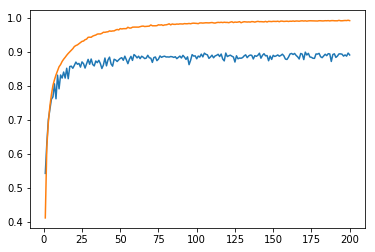

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(1,201),df['test_acc'])
plt.plot(range(1,201),df['train_acc'])

In [68]:
import numpy as np
np.max(df['test_acc'])

0.8994000017642975